In [170]:
# importar librerias necesarias para exploratory analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})

import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 31)
#pd.set_option('display.max_rows', 150)
#pd.set_option("display.float_format", lambda x: "%.4f" % x)

## modelamiento

from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
     
from sklearn.model_selection import StratifiedKFold

import plotly.graph_objs as go

from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import xgboost as xgb


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz


import shap
from sklearn.preprocessing import RobustScaler

In [171]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

def null_plot(data, title=""):
    
    order = data.isnull().sum().sort_values(ascending=False).index
    
    fig, ax = plt.subplots(figsize=(18,10))
    cmap = sns.mpl_palette("Set2", 2)
    sns.heatmap(data=data.isnull().reindex(order, axis=1), cmap=cmap, cbar=False, yticklabels=len(data)//30)
    
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.suptitle(t=title, x=0.14, y=0.98, fontsize = 20, fontweight="semibold")
    legend_handles = [Patch(color=cmap[True], label='Missing Value'),
                      Patch(color=cmap[False], label='Non Missing Value')] 
    plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.86, 1.02], loc='lower center', fontsize=15, handlelength=.8)
    plt.tight_layout()
    plt.savefig("figura", format='png')
    plt.show()
    
    
def null_plot_ordered(df, col):
    data = df.copy()
    data.index = data[col]
    return(null_plot(data.sort_index(ascending=False)))


def categ_plots_grouped(df_grouped, column_to_plot):
    tabla = df_grouped[column_to_plot].value_counts().unstack()
    tabla.loc["Total"] = df_grouped[column_to_plot].value_counts().unstack().sum().tolist()
    display(tabla)

    tabla2 = df_grouped[column_to_plot].value_counts().unstack().apply(lambda x: x/sum(x))
    display(tabla2)
    
    plt.figure(figsize=(15,3))
    tabla2.loc[1].plot(kind="bar")
    plt.title(column_to_plot)
    
def stats_describe(data):
    stats = data.describe()
    stats.loc["var"] = data.var().tolist()
    stats.loc["skewness"] = data.skew().tolist()
    stats.loc["kurtosis"] = data.kurtosis().tolist()
    stats.loc["count_nan"] = data.isnull().sum()
    stats.loc["pct_nan"] = (data.isnull().sum()/len(data))
    stats.loc["dtype"] = data.dtypes
    stats.loc["nunique"] = data.nunique()
    return stats.T

def roc_graph(model, dataset, true_values):   
    predictions=model.predict_proba(dataset)
    auc=roc_auc_score(true_values, predictions[:,1])
    fpr, tpr, _ =roc_curve(true_values, predictions[:,1])
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label="GB ; AUC=" + "{:.3f}".format(auc))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.legend(loc="best")
    plt.show()

### Exploratory analysis

In [172]:
train_df = pd.read_csv('creditcard_train.csv')
test_df = pd.read_csv('creditcard_test.csv')

In [173]:
train_df

Amount      Time        V1       V10       V11       V12       V13  \
0         21.24   72390.0 -1.005813  0.175746 -1.381102 -0.312333 -0.223930   
1       1084.45   79686.0 -2.095382 -2.325235 -0.390857 -0.424692 -0.984848   
2          3.74   72729.0 -1.872940 -0.568226 -0.604709  0.793920  0.901921   
3          0.00   58686.0 -0.365579 -0.508538  0.199901  0.360366  0.213366   
4          1.00  157994.0  2.051674  0.266912 -0.996228  0.365151 -0.152766   
...         ...       ...       ...       ...       ...       ...       ...   
270561   926.67  128407.0  0.244865 -1.241246 -0.656672 -0.190093 -0.982428   
270562     9.99  152873.0 -0.537987 -0.820872 -1.608655  0.062242 -0.272606   
270563    12.99  145341.0 -1.440688 -0.321941 -0.510487  0.432947 -0.204318   
270564  1558.00  126188.0 -0.861493 -0.472789  0.017484  0.181201 -0.119470   
270565     0.89  161036.0 -0.132431 -0.207852 -1.729515  0.025511  0.598884   

             V14       V15       V16       V17       V18       V19        V2  \
0       0.480866  1.075049  0.046077 -0.248195  0.443675  0.626808  1.736662   
1       0.034249  1.476836 -0.636633  0.175802  0.043461  0.470724 -1.385872   
2       0.786029  1.498281  0.126029  0.344861 -0.129090 -0.048887  1.797359   
3       0.212513 -0.279438  0.860700 -1.218899  0.292825  0.364666  0.755101   
4       0.505194 -0.579676 -0.689585 -0.186241 -0.589570 -0.153442  0.272888   
...          ...       ...       ...       ...       ...       ...       ...   
270561 -1.035917  0.146160  0.106735  1.197437  0.255629 -0.207808 -2.935385   
270562 -0.223797 -0.383484  0.374224 -0.822866  0.458453 -0.927835  0.774122   
270563  0.953653 -0.005159  0.094775 -0.105154 -0.787898 -0.240131  1.397525   
270564  1.382821  0.372575 -0.657654 -0.104705 -0.557822 -0.526082 -5.083086   
270565 -0.097289 -0.308511  0.109494 -0.770158 -0.560573  0.244660  0.978327   

             V20       V21       V22       V23       V24       V25       V26  \
0      -0.622567  2.351990 -0.514170  0.171007 -0.497098 -0.008236 -0.293881   
1       0.065856  0.005589  0.412600  0.844514  0.090658  0.744140 -0.539940   
2      -0.422028  0.284888  0.357907  0.203695  0.074903 -0.650199 -0.533393   
3      -0.078255 -0.102506 -0.421576 -0.121036 -0.804540 -0.627087  0.649085   
4      -0.304303  0.041303  0.365279 -0.002065  0.054471  0.478429 -0.494708   
...          ...       ...       ...       ...       ...       ...       ...   
270561  1.611841  0.298892 -0.996756 -0.611389 -0.179716 -0.440728 -0.175587   
270562 -0.618909  1.853090  0.598353  0.187580  0.559790 -1.001229 -0.517318   
270563 -0.151382 -0.193183 -0.755063  0.234305  0.685659 -0.390991  0.119076   
270564  2.999111  1.195048 -0.016167 -1.499410  0.899844  0.083866  0.873379   
270565 -0.022038 -0.285509 -0.706807 -0.030883 -1.060743 -0.370461  0.182028   

             V27       V28        V3        V4        V5        V6        V7  \
0      -0.214084 -0.245146  0.166298  0.685339  0.013481  0.172307 -0.257151   
1       0.443988 -0.189782  0.210828 -0.984654 -4.323515  2.039752  4.678400   
2      -0.649888 -0.077926  0.696415  0.915173 -1.065011 -0.102628 -0.826427   
3      -0.090770  0.130239  0.761883 -1.505144  0.653529 -0.236665  0.695951   
4      -0.015667 -0.062459 -1.573955  1.393719  0.407621 -1.239977  0.656515   
...          ...       ...       ...       ...       ...       ...       ...   
270561 -0.183370  0.135004 -2.641925  1.212391 -0.927223 -0.887115  1.258957   
270562  0.376091  0.284846  0.612170 -1.026679  0.159618  0.195108 -0.242569   
270563 -0.419360 -0.292485 -2.335104 -1.697712  2.052002  3.261111 -0.535727   
270564 -0.420973  0.166541 -5.586561  0.401128  1.637514  3.202323  2.416523   
270565 -0.018241  0.080455 -0.210734 -0.875679  0.972044 -0.429428  0.979242   

              V8        V9  Class  
0      -2.281020 -0.163937      0  
1      -0.614914  0.766196      0  
2       1.250767 -0.613325      0  
3      -0.016420 -0.389425      0

In [174]:
test_df

Amount      Time        V1       V10       V11       V12       V13  \
0        3.87     132.0 -0.394816 -0.387105 -0.748656  0.317262  1.209455   
1      129.73  153434.0  1.788871  0.769936  0.039972  0.012588 -0.883865   
2        1.98  155725.0  2.064625 -0.409513 -0.364298  0.585688  0.829608   
3        0.77  156221.0 -1.575180  0.290898  0.446495  0.616709 -0.365459   
4        1.29  144427.0  2.064998 -0.370744 -0.587547 -0.110537 -0.479552   
...       ...       ...       ...       ...       ...       ...       ...   
14236    6.99   81941.0  1.219269  0.104569  1.081049  0.762845  0.033258   
14237   21.00   94766.0 -0.038516 -0.293283  0.456979 -2.419304  1.145454   
14238    1.29   87479.0  2.055343  0.027649 -0.473535  1.135669  1.333175   
14239   25.00    3263.0 -0.104979  0.533233  0.994111  0.219665  0.838210   
14240   39.90   85273.0  1.319814  0.752926 -0.542543 -0.117493  0.370550   

            V14       V15       V16       V17       V18       V19        V2  \
0     -0.089114  1.045811  0.101501 -0.479842 -0.656485 -0.035922  1.054418   
1     -0.077202  0.430576 -0.626788 -0.724333  2.616003 -0.927266 -1.609232   
2     -0.991170  0.166048  0.214684  0.494281 -0.499171 -0.033218  0.205540   
3     -0.075622 -0.262793  0.385753 -0.832068  0.384723  0.159865  1.458531   
4     -0.730811  0.309585  0.275997  0.569065 -0.338709 -0.024160  0.112909   
...         ...       ...       ...       ...       ...       ...       ...   
14236  0.359111  0.484284  0.702875 -0.832088  0.345603  0.169439  0.069726   
14237  0.916726 -1.265461 -1.165619  0.709838 -0.484892  0.904466  0.534755   
14238  0.027602 -0.052358 -0.223572 -0.304456 -1.114867  0.065799  0.034796   
14239 -0.024492 -1.180382  1.137234 -0.356103 -1.000609  0.341051  0.326376   
14240  0.177993  0.795444 -1.362906 -0.085248  0.993349 -0.939500 -0.389476   

            V20       V21       V22       V23       V24       V25       V26  \
0      0.160783 -0.243154 -0.548388 -0.107138 -0.757097 -0.119197  0.149368   
1     -0.440207 -0.024857  0.253865  0.145478 -0.460257 -0.564027 -0.270155   
2     -0.113004 -0.348162 -0.853455  0.339981  0.529735 -0.250244  0.172699   
3      0.354805 -0.232099 -0.362648 -0.072512 -0.445475 -0.140472 -0.277620   
4     -0.198280 -0.363631 -0.960298  0.356301  0.493859 -0.294282  0.177159   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.074539 -0.075446 -0.250334  0.010486  0.006473  0.270530  0.234377   
14237  0.069741 -0.654840 -1.162169  0.112984  0.569864 -0.869850 -1.095726   
14238 -0.150138 -0.269053 -0.570930  0.332103  0.021611 -0.270185  0.196849   
14239  0.226259  0.380917  1.103479 -0.058097  0.060992 -0.585920 -0.424593   
14240 -0.434379 -0.345765 -0.570930 -0.008269  0.401972  0.382698  0.500534   

            V27       V28        V3        V4        V5        V6        V7  \
0      0.287360  0.111322  1.206361 -0.289232  0.610284  0.081529  0.687721   
1      0.066486 -0.013645  0.117193 -0.260803 -1.742005  0.318536 -1.551666   
2     -0.054478 -0.029073 -1.678882  0.408388  0.504149 -0.791406  0.224242   
3      0.246154  0.077137  0.996709 -1.379689 -0.231059 -0.108209  0.159405   
4     -0.062905 -0.032004 -1.705326  0.420547  0.388005 -0.822799  0.134514   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.025057  0.007338  0.557817  0.449976 -0.445903 -0.356850 -0.247844   
14237 -0.196449 -0.252792  0.346520  0.181320  2.881003  4.651889  0.261806   
14238 -0.059141 -0.057850 -1.039231  0.396207  0.001705 -1.098979  0.255820   
14239  0.424716  0.268164  0.208022 -1.892027  0.237738 -1.023539  0.680444   
14240 -0.030260  0.018835  0.236381 -0.098582 -0.920255 -1.028215 -0.218477   

             V8        V9  
0      0.065341 -0.501623  
1      0.326577  0.679773  
2     -0.256225  0.373726  
3      0.465605  0.893678  
4     -0.181677  0.572015  
...         ...       ...  
14236  0.032738  0.003935  
14237  0.59

In [175]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270566 entries, 0 to 270565
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Amount  270566 non-null  float64
 1   Time    270566 non-null  float64
 2   V1      270566 non-null  float64
 3   V10     270566 non-null  float64
 4   V11     270566 non-null  float64
 5   V12     270566 non-null  float64
 6   V13     270566 non-null  float64
 7   V14     270566 non-null  float64
 8   V15     270566 non-null  float64
 9   V16     270566 non-null  float64
 10  V17     270566 non-null  float64
 11  V18     270566 non-null  float64
 12  V19     270566 non-null  float64
 13  V2      270566 non-null  float64
 14  V20     270566 non-null  float64
 15  V21     270566 non-null  float64
 16  V22     270566 non-null  float64
 17  V23     270566 non-null  float64
 18  V24     270566 non-null  float64
 19  V25     270566 non-null  float64
 20  V26     270566 non-null  float64
 21  V27     27

In [176]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14241 entries, 0 to 14240
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  14241 non-null  float64
 1   Time    14241 non-null  float64
 2   V1      14241 non-null  float64
 3   V10     14241 non-null  float64
 4   V11     14241 non-null  float64
 5   V12     14241 non-null  float64
 6   V13     14241 non-null  float64
 7   V14     14241 non-null  float64
 8   V15     14241 non-null  float64
 9   V16     14241 non-null  float64
 10  V17     14241 non-null  float64
 11  V18     14241 non-null  float64
 12  V19     14241 non-null  float64
 13  V2      14241 non-null  float64
 14  V20     14241 non-null  float64
 15  V21     14241 non-null  float64
 16  V22     14241 non-null  float64
 17  V23     14241 non-null  float64
 18  V24     14241 non-null  float64
 19  V25     14241 non-null  float64
 20  V26     14241 non-null  float64
 21  V27     14241 non-null  float64
 22

cosas que noto antes de empezar con el EDA:

* No se encuentran NAN, asi que no eliminaremos por % de Nan, en el training set, 

* como tenemos clases es un modelo de clasificacion 

* no sabemos las variable que son no creo que podamos saber v1 a v28 estan escaldas , y amount no se en que monto esta asumire dolares y time no se en que esta probablemente segundos

* data muy desbalanceada se va a tener que trabajar con los pesos para tener un modelo decente(he trabajado con SMOTE pero no lo recomiendo aqui ocupare pesos para ver que se puede hacer), si tienes dudas por que no ocupe SMOTE eso da para una larga charla 

# EDA
solo Amount y Time tienen mas valores repetidos, los otros casi no tienen valores repetidos y ninguno tiene Nan

In [177]:
TE_stats_describe = stats_describe(train_df)
TE_stats_describe

count        mean           std         min       25%       50%  \
Amount  270566.0   88.318515    250.502575         0.0      5.53      22.0   
Time    270566.0  94844.1307  47484.976042         0.0  54237.25   84733.0   
V1      270566.0   -0.000534      1.960822   -56.40751  -0.92078  0.017713   
V10     270566.0      0.0008      1.090202  -24.588262 -0.534672 -0.092375   
V11     270566.0   -0.000618      1.020667   -4.797473 -0.762919  -0.03353   
V12     270566.0    0.000265      0.999547  -18.683715  -0.40479  0.140732   
V13     270566.0   -0.000602      0.994917   -5.791881 -0.648452 -0.014718   
V14     270566.0    0.000047      0.957894  -19.214325 -0.424849  0.050258   
V15     270566.0    0.000435      0.915274   -4.498945 -0.582659  0.048238   
V16     270566.0   -0.001197      0.877117  -14.129855 -0.468853  0.065851   
V17     270566.0   -0.000708      0.850112  -25.162799 -0.483825 -0.065921   
V18     270566.0   -0.000112      0.838075   -9.498746  -0.49865 -0.003985   
V19     270566.0    0.000328      0.814468   -7.213527 -0.456202  0.003525   
V2      270566.0   -0.000784       1.65624  -72.715728  -0.59884  0.065354   
V20     270566.0   -0.000644      0.773384   -54.49772 -0.212057  -0.06271   
V21     270566.0    0.000436      0.731757  -34.830382 -0.228397 -0.029575   
V22     270566.0    -0.00016      0.725273  -10.933144 -0.542285  0.006967   
V23     270566.0    0.000336      0.623946  -44.807735 -0.161503 -0.010982   
V24     270566.0    -0.00019      0.605308   -2.836627 -0.354518  0.040836   
V25     270566.0     -0.0003      0.521142  -10.295397 -0.317319  0.016308   
V26     270566.0    0.000164      0.482291   -2.604551 -0.326992 -0.051676   
V27     270566.0   -0.000119      0.404914  -22.565679 -0.070897  0.001321   
V28     270566.0    -0.00002      0.332742  -15.430084 -0.053041  0.011169   
V3      270566.0    0.000097      1.515354  -48.325589 -0.890456  0.179523   
V4      270566.0   -0.000264      1.416879   -5.683171 -0.848835 -0.020333   
V5      270566.0    0.000043      1.383808 -113.743307 -0.691872 -0.054607   
V6      270566.0   -0.001158      1.333188  -26.160506 -0.768571 -0.274903   
V7      270566.0    0.000363      1.239431  -43.557242 -0.554015   0.04014   
V8      270566.0    0.000541      1.184683  -73.216718 -0.208844  0.022071   
V9      270566.0   -0.000217      1.098665  -13.434066 -0.643091 -0.051616   
Class   270566.0    0.001726       0.04151         0.0       0.0       0.0   

              75%         max                var   skewness    kurtosis  \
Amount    77.0475    25691.16       62751.539868  17.287807  875.811896   
Time    139334.75    172792.0  2254822949.688742  -0.036602   -1.293017   
V1       1.315781     2.45493           3.844821  -3.293323   32.765431   
V10      0.455022   23.745136            1.18854   1.155624   32.525098   
V11      0.739018   12.018913           1.041761   0.362956    1.682983   
V12      0.618464    7.848392           0.999093   -2.31395   20.824181   
V13      0.661209    7.126883           0.989859   0.066017    0.197591   
V14      0.492591   10.526766            0.91756  -2.024494   24.366284   
V15      0.649423    8.877742           0.837727  -0.307526    0.289924   
V16      0.522352   17.315112           0.769335  -1.122641   10.730713   
V17      0.399291    9.207059           0.722691  -3.957992   97.243939   
V18      0.500884    5.041069            0.70237  -0.269082    2.648433   
V19      0.459204    5.591971           0.663357   0.110463    1.726999   
V2       0.803364   22.057729           2.743132  -4.721074   98.062943   
V20      0.132626   39.420904           0.598123  -2.050049  276.450391   
V21      0.186145   27.202839           0.535468   3.688302  204.485771   
V22      0.528165    10.50309            0.52602  -0.218982    2.747761   
V23      0.147951   22.528412           0.389309  -5.817061  447.343682   
V24       0.43921    4.584549           0.366398   -0.55365    0.618821   
V25      0.350

In [178]:
train_df.describe()

Amount           Time             V1            V10  \
count  270566.000000  270566.000000  270566.000000  270566.000000   
mean       88.318515   94844.130700      -0.000534       0.000800   
std       250.502575   47484.976042       1.960822       1.090202   
min         0.000000       0.000000     -56.407510     -24.588262   
25%         5.530000   54237.250000      -0.920780      -0.534672   
50%        22.000000   84733.000000       0.017713      -0.092375   
75%        77.047500  139334.750000       1.315781       0.455022   
max     25691.160000  172792.000000       2.454930      23.745136   

                 V11            V12            V13            V14  \
count  270566.000000  270566.000000  270566.000000  270566.000000   
mean       -0.000618       0.000265      -0.000602       0.000047   
std         1.020667       0.999547       0.994917       0.957894   
min        -4.797473     -18.683715      -5.791881     -19.214325   
25%        -0.762919      -0.404790      -0.648452      -0.424849   
50%        -0.033530       0.140732      -0.014718       0.050258   
75%         0.739018       0.618464       0.661209       0.492591   
max        12.018913       7.848392       7.126883      10.526766   

                 V15            V16            V17            V18  \
count  270566.000000  270566.000000  270566.000000  270566.000000   
mean        0.000435      -0.001197      -0.000708      -0.000112   
std         0.915274       0.877117       0.850112       0.838075   
min        -4.498945     -14.129855     -25.162799      -9.498746   
25%        -0.582659      -0.468853      -0.483825      -0.498650   
50%         0.048238       0.065851      -0.065921      -0.003985   
75%         0.649423       0.522352       0.399291       0.500884   
max         8.877742      17.315112       9.207059       5.041069   

                 V19             V2            V20            V21  \
count  270566.000000  270566.000000  270566.000000  270566.000000   
mean        0.000328      -0.000784      -0.000644       0.000436   
std         0.814468       1.656240       0.773384       0.731757   
min        -7.213527     -72.715728     -54.497720     -34.830382   
25%        -0.456202      -0.598840      -0.212057      -0.228397   
50%         0.003525       0.065354      -0.062710      -0.029575   
75%         0.459204       0.803364       0.132626       0.186145   
max         5.591971      22.057729      39.420904      27.202839   

                 V22            V23            V24            V25  \
count  270566.000000  270566.000000  270566.000000  270566.000000   
mean       -0.000160       0.000336      -0.000190      -0.000300   
std         0.725273       0.623946       0.605308       0.521142   
min       -10.933144     -44.807735      -2.836627     -10.295397   
25%        -0.542285      -0.161503      -0.354518      -0.317319   
50%         0.006967      -0.010982       0.040836       0.016308   
75%         0.528165       0.147951       0.439210       0.350318   
max        10.503090      22.528412       4.584549       7.519589   

                 V26            V27            V28             V3  \
count  270566.000000  270566.000000  270566.000000  270566.000000   
mean        0.000164      -0.000119      -0.000020       0.000097   
std         0.482291       0.404914       0.332742       1.515354   
min        -2.604551     -22.565679     -15.430084     -48.325589   
25%        -0.326992      -0.070897      -0.053041      -0.890456   
50%        -0.051676       0.001321       0.011169       0.179523   
75%         0.241373       0.091125       0.078228       1.027066   
max         3.517346      31.612198      33.847808       9.382558   

                  V4             V5             V6             V7  \
count  270566.000000  270566.000000  270566.000000  270566.000000   
mean       -0.000264       0.000043      -0.001158       0.000363   
std         1.416879       1.383808       1.333188       1.239431   
min   

### Transactions amount

parece que que los fraudes fueron de valores mas pequenos

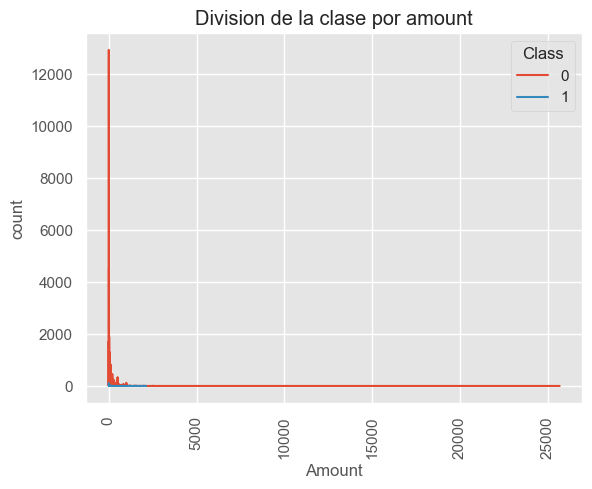

In [179]:
data = train_df.groupby("Class")['Amount'].value_counts().rename("count").reset_index()#.pivot_table(index="Ano_Mes", columns="Target_")
sns.lineplot(data=data, x="Amount", y="count",hue="Class")
plt.xticks(rotation=90)
plt.title("Division de la clase por amount")
plt.xlabel("Amount")
plt.show()

asi que filtramos para poder observar en que rango se concentran los fraudes, en los tres graficos 

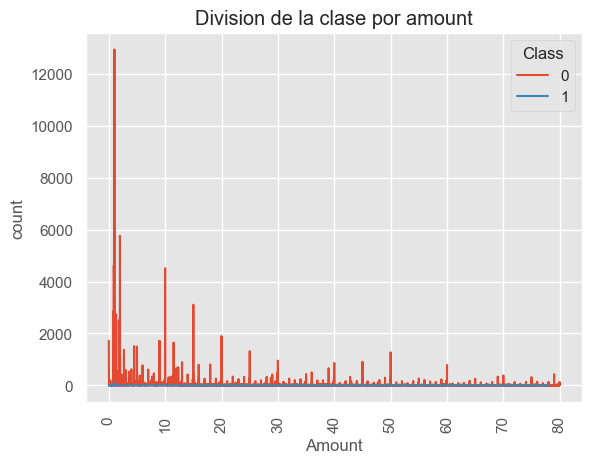

In [180]:
mcinco=train_df.loc[train_df["Amount"]<80]
data = mcinco.groupby("Class")['Amount'].value_counts().rename("count").reset_index()#.pivot_table(index="Ano_Mes", columns="Target_")
sns.lineplot(data=data, x="Amount", y="count",hue="Class")
plt.xticks(rotation=90)
plt.title("Division de la clase por amount")
plt.xlabel("Amount")
plt.show()

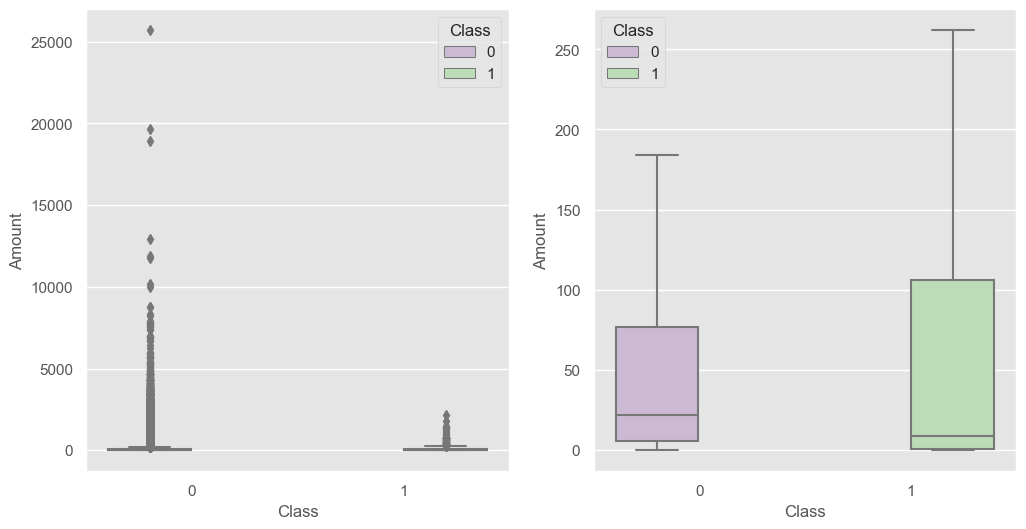

In [181]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=train_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=train_df, palette="PRGn",showfliers=False)
plt.show();


In [268]:
fraud = train_df.loc[train_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount de transacciones fraudulentas',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

In [183]:
tmp = train_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    270099.000000
mean         88.259318
std         250.481582
min           0.000000
25%           5.590000
50%          22.000000
75%          77.000000
max       25691.160000
Name: Amount, dtype: float64

In [184]:
class_1.describe()

count     467.000000
mean      122.555974
std       260.394107
min         0.000000
25%         1.000000
50%         8.900000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

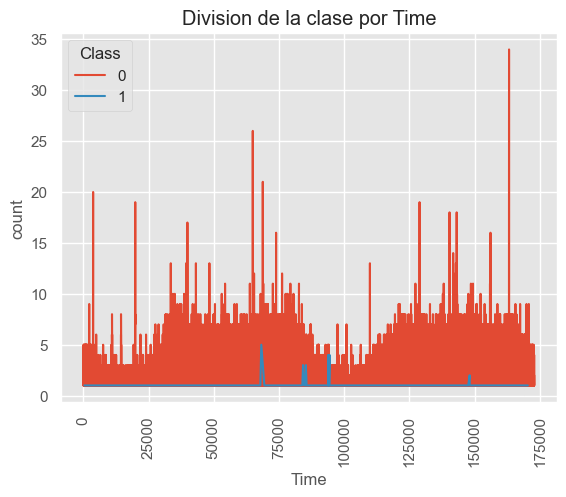

In [186]:
data = train_df.groupby("Class")['Time'].value_counts().rename("count").reset_index()#.pivot_table(index="Ano_Mes", columns="Target_")
sns.lineplot(data=data, x="Time", y="count",hue="Class")
plt.xticks(rotation=90)
plt.title("Division de la clase por Time")
plt.xlabel("Time")
plt.show()

In [185]:
train_df['Hour'] = train_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = train_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

Hour  Class   Min      Max  Transactions        Sum        Mean   Median  \
0   0.0      0   0.0  7712.43          3787  246404.17   65.065796   12.990   
1   0.0      1   0.0   529.00             2     529.00  264.500000  264.500   
2   1.0      0   0.0  1769.69          2094  138538.59   66.159785   22.550   
3   1.0      1  59.0   239.93             2     298.93  149.465000  149.465   
4   2.0      0   0.0  4002.88          1477  103864.05   70.320955   17.990   

             Var  
0   46698.129489  
1  139920.500000  
2   20343.476981  
3   16367.832450  
4   47473.135856

In [187]:
train_df['Class'].value_counts()

0    270099
1       467
Name: Class, dtype: int64

solo 0.17% de este dataset son fraudes ocupare pesos para intentar balancear para el modelo

In [188]:

train_df["Class"].value_counts(normalize=True)

0    0.998274
1    0.001726
Name: Class, dtype: float64

<AxesSubplot: xlabel='Class', ylabel='count'>

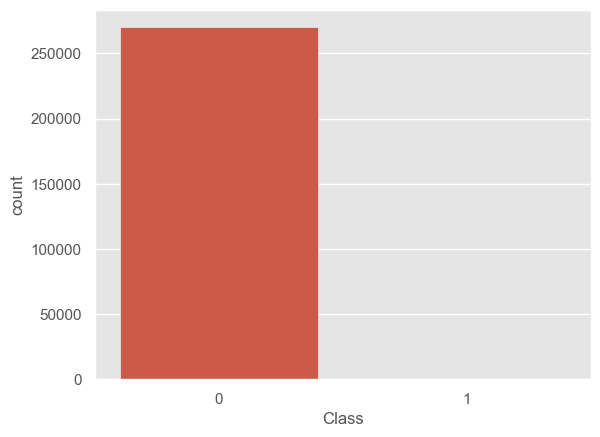

In [189]:
sns.countplot(x=train_df["Class"])

In [269]:
class_0 = train_df.loc[train_df['Class'] == 0]["Time"]
class_1 = train_df.loc[train_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Transactions de tarjetas de credito Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

<Figure size 640x480 with 0 Axes>

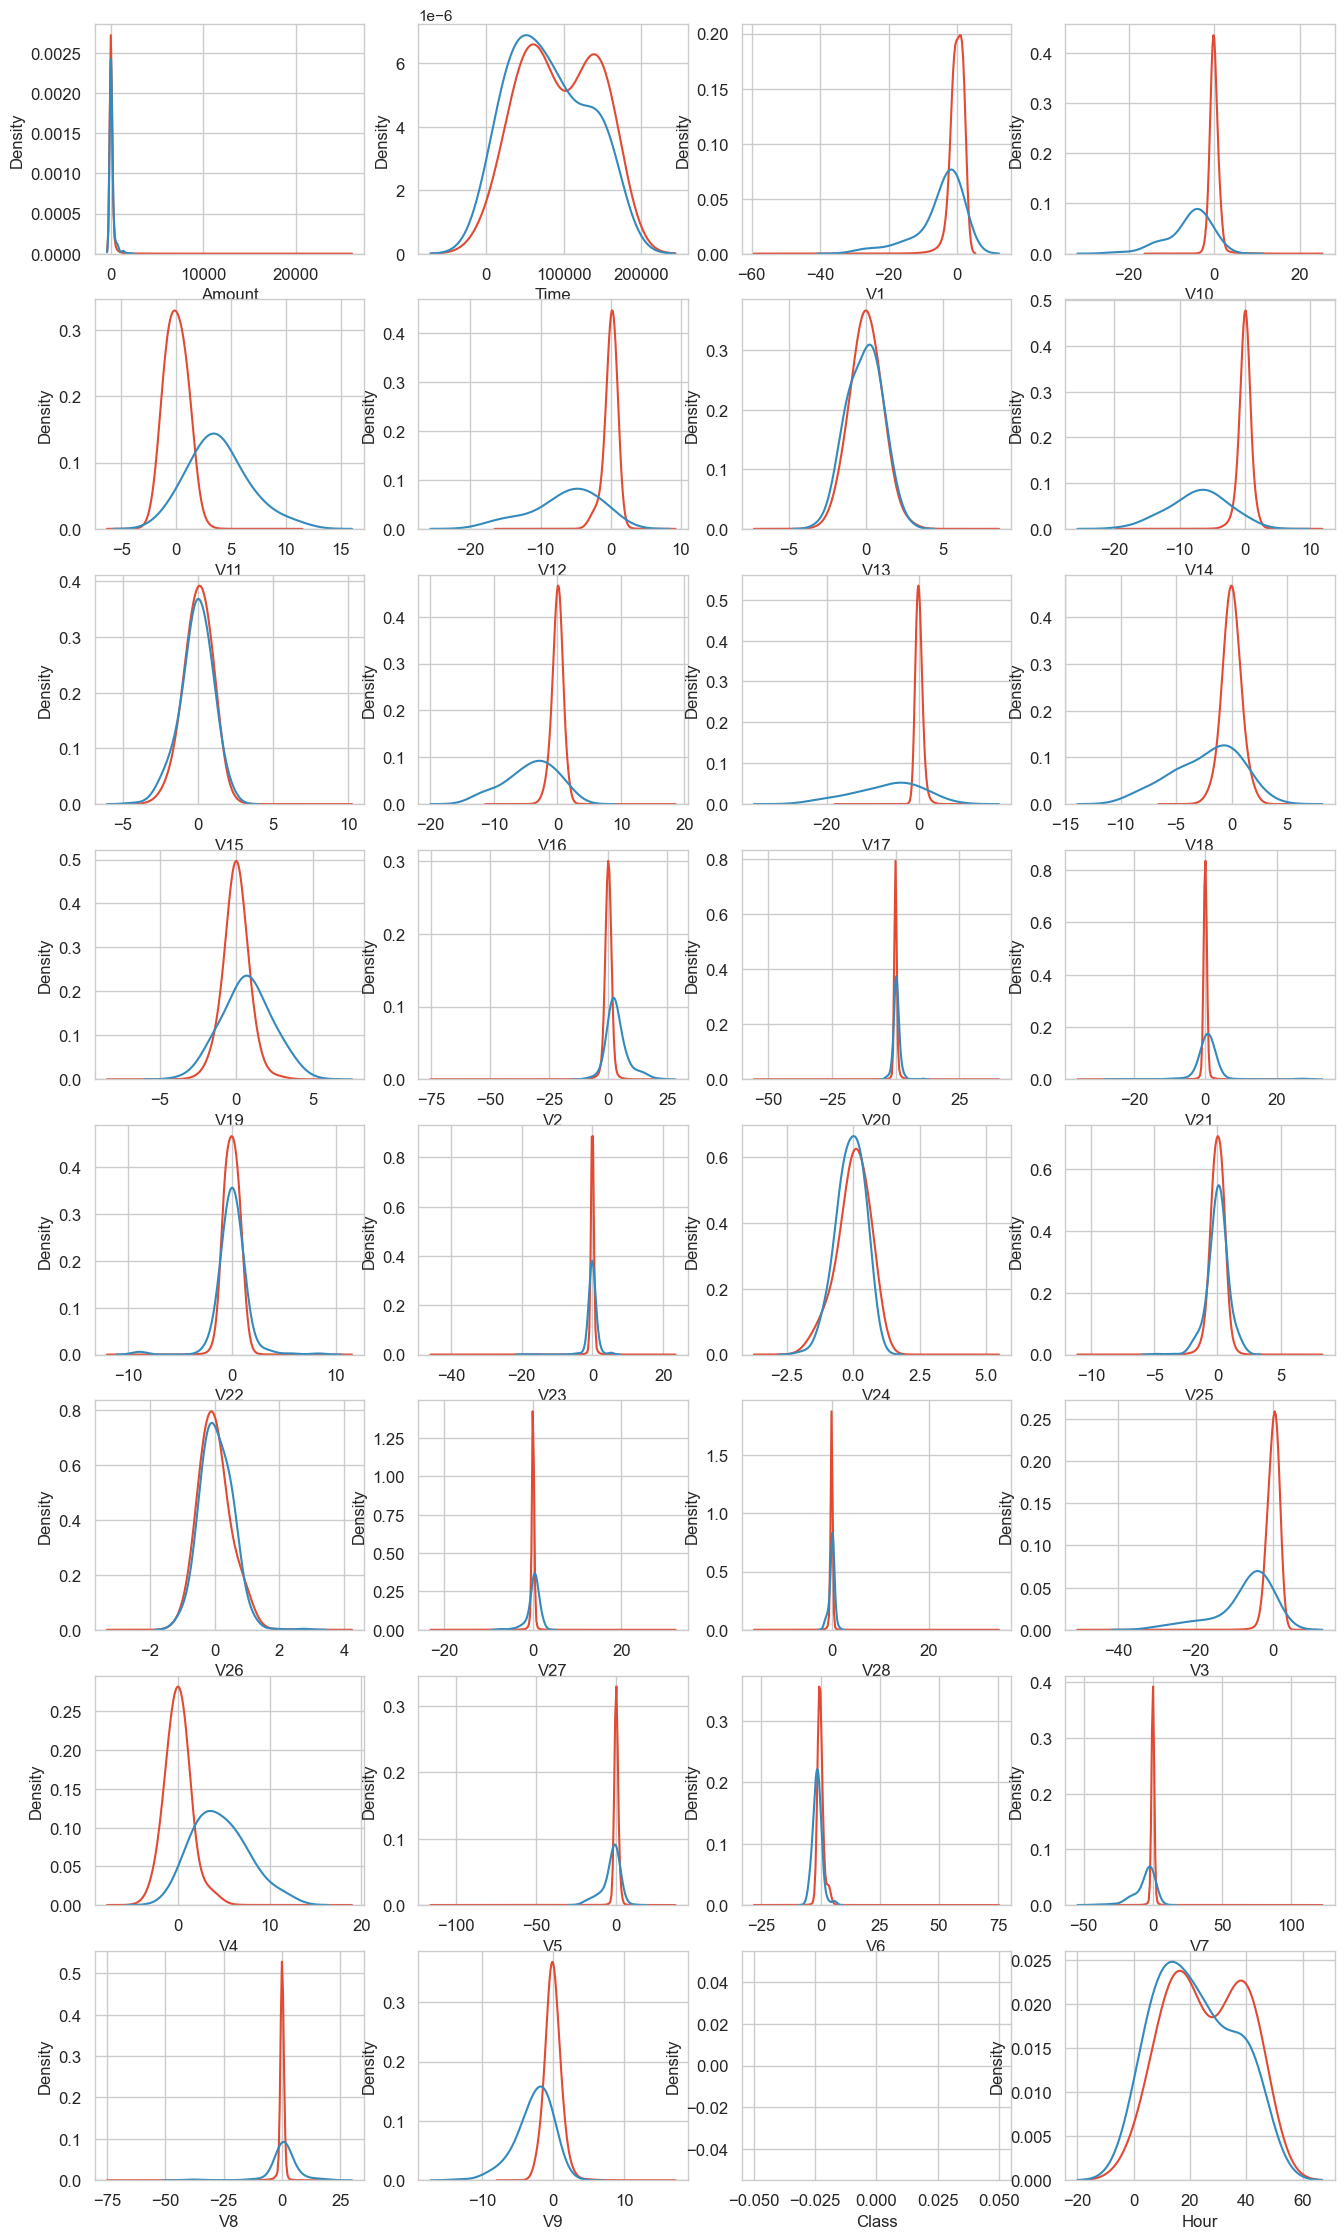

In [191]:
var = train_df.columns.values

i = 0
t0 = train_df.loc[train_df['Class'] == 0]
t1 = train_df.loc[train_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Para algunas de las características, podemos observar una buena selectividad en términos de distribución para los dos valores de Clase: V4, V11 tienen distribuciones claramente separadas para los valores de Clase 0 y 1, V12, V14, V18 están parcialmente separados, V1, V2, V3, V10 tienen un perfil bastante distintivo, mientras que V25, V26, V28 tienen perfiles similares para los dos valores de Clase.

En general, con pocas excepciones (Time y Amount), la distribución de características para transacciones legítimas (valores de Clase = 0) se centra alrededor de 0, a veces con una larga cola en uno de los extremos. Al mismo tiempo, las transacciones fraudulentas (valores de Clase = 1) tienen una distribución sesgada (asimétrica).

In [192]:
train_df.drop('Hour', axis=1,inplace=True)

In [193]:
train_df

Amount      Time        V1       V10       V11       V12       V13  \
0         21.24   72390.0 -1.005813  0.175746 -1.381102 -0.312333 -0.223930   
1       1084.45   79686.0 -2.095382 -2.325235 -0.390857 -0.424692 -0.984848   
2          3.74   72729.0 -1.872940 -0.568226 -0.604709  0.793920  0.901921   
3          0.00   58686.0 -0.365579 -0.508538  0.199901  0.360366  0.213366   
4          1.00  157994.0  2.051674  0.266912 -0.996228  0.365151 -0.152766   
...         ...       ...       ...       ...       ...       ...       ...   
270561   926.67  128407.0  0.244865 -1.241246 -0.656672 -0.190093 -0.982428   
270562     9.99  152873.0 -0.537987 -0.820872 -1.608655  0.062242 -0.272606   
270563    12.99  145341.0 -1.440688 -0.321941 -0.510487  0.432947 -0.204318   
270564  1558.00  126188.0 -0.861493 -0.472789  0.017484  0.181201 -0.119470   
270565     0.89  161036.0 -0.132431 -0.207852 -1.729515  0.025511  0.598884   

             V14       V15       V16       V17       V18       V19        V2  \
0       0.480866  1.075049  0.046077 -0.248195  0.443675  0.626808  1.736662   
1       0.034249  1.476836 -0.636633  0.175802  0.043461  0.470724 -1.385872   
2       0.786029  1.498281  0.126029  0.344861 -0.129090 -0.048887  1.797359   
3       0.212513 -0.279438  0.860700 -1.218899  0.292825  0.364666  0.755101   
4       0.505194 -0.579676 -0.689585 -0.186241 -0.589570 -0.153442  0.272888   
...          ...       ...       ...       ...       ...       ...       ...   
270561 -1.035917  0.146160  0.106735  1.197437  0.255629 -0.207808 -2.935385   
270562 -0.223797 -0.383484  0.374224 -0.822866  0.458453 -0.927835  0.774122   
270563  0.953653 -0.005159  0.094775 -0.105154 -0.787898 -0.240131  1.397525   
270564  1.382821  0.372575 -0.657654 -0.104705 -0.557822 -0.526082 -5.083086   
270565 -0.097289 -0.308511  0.109494 -0.770158 -0.560573  0.244660  0.978327   

             V20       V21       V22       V23       V24       V25       V26  \
0      -0.622567  2.351990 -0.514170  0.171007 -0.497098 -0.008236 -0.293881   
1       0.065856  0.005589  0.412600  0.844514  0.090658  0.744140 -0.539940   
2      -0.422028  0.284888  0.357907  0.203695  0.074903 -0.650199 -0.533393   
3      -0.078255 -0.102506 -0.421576 -0.121036 -0.804540 -0.627087  0.649085   
4      -0.304303  0.041303  0.365279 -0.002065  0.054471  0.478429 -0.494708   
...          ...       ...       ...       ...       ...       ...       ...   
270561  1.611841  0.298892 -0.996756 -0.611389 -0.179716 -0.440728 -0.175587   
270562 -0.618909  1.853090  0.598353  0.187580  0.559790 -1.001229 -0.517318   
270563 -0.151382 -0.193183 -0.755063  0.234305  0.685659 -0.390991  0.119076   
270564  2.999111  1.195048 -0.016167 -1.499410  0.899844  0.083866  0.873379   
270565 -0.022038 -0.285509 -0.706807 -0.030883 -1.060743 -0.370461  0.182028   

             V27       V28        V3        V4        V5        V6        V7  \
0      -0.214084 -0.245146  0.166298  0.685339  0.013481  0.172307 -0.257151   
1       0.443988 -0.189782  0.210828 -0.984654 -4.323515  2.039752  4.678400   
2      -0.649888 -0.077926  0.696415  0.915173 -1.065011 -0.102628 -0.826427   
3      -0.090770  0.130239  0.761883 -1.505144  0.653529 -0.236665  0.695951   
4      -0.015667 -0.062459 -1.573955  1.393719  0.407621 -1.239977  0.656515   
...          ...       ...       ...       ...       ...       ...       ...   
270561 -0.183370  0.135004 -2.641925  1.212391 -0.927223 -0.887115  1.258957   
270562  0.376091  0.284846  0.612170 -1.026679  0.159618  0.195108 -0.242569   
270563 -0.419360 -0.292485 -2.335104 -1.697712  2.052002  3.261111 -0.535727   
270564 -0.420973  0.166541 -5.586561  0.401128  1.637514  3.202323  2.416523   
270565 -0.018241  0.080455 -0.210734 -0.875679  0.972044 -0.429428  0.979242   

              V8        V9  Class  
0      -2.281020 -0.163937      0  
1      -0.614914  0.766196      0  
2       1.250767 -0.613325      0  
3      -0.016420 -0.389425      0

### Feature selection

Information value una medida del poder predictivo de una característica en un problema de clasificación binaria. Se calcula como la diferencia entre el peso de la evidencia (Woe) de la característica en la clase positiva y en la clase negativa, multiplicada por el logaritmo natural de la relación entre el porcentaje de muestras de clase positiva y el porcentaje de muestras de clase negativa2.

Un buen valor de información es aquel que es superior a 0,1, mientras que un mal valor de información es aquel que es inferior a 0,01. Valores mayores de 5 son extranos y puede que esa variable tenga data leakage

In [194]:
### CALCULO DE IV
lista=train_df.columns.to_list()
lista_final=lista = [x for x in lista if x not in [ "Class"]]              
lista_final
nuevo_binning=pd.DataFrame()
cortes=pd.DataFrame()
h=pd.DataFrame()
n=pd.DataFrame()
#var_woe=pd.DataFrame()

for v in lista_final:
    variable = str(v)
    a = train_df[variable].values
    b = train_df['Class']
    c=b
    from optbinning import OptimalBinning
    optb = OptimalBinning(name=variable, dtype="numerical", solver="cp",monotonic_trend='auto_asc_desc', special_codes=[-999],min_prebin_size=0.05)
    optb.fit(a, c)
    binning_table = optb.binning_table
    t=binning_table.build()
    t['Variable']=variable
    p=t['IV'].sum()/2
    h=pd.DataFrame()
    h=pd.DataFrame(data={"VARIABLE": v,'IV':p}, index=[0])
    n=n.append(h)
    print(variable+" : IV____"+str(p))
    nuevo_binning=nuevo_binning.append(t)
    #var_woe[str(v)+'_w'] = optb.transform(a, metric="woe")
    m=optb.splits
    w=pd.DataFrame()
    w=pd.DataFrame(data={"cortes": m,'Variable':v})
    cortes=cortes.append(w)

Amount : IV____0.45104901329934166
Time : IV____0.21399153803880805
V1 : IV____1.724163387983898
V10 : IV____3.787602825302952
V11 : IV____3.5504872671130916
V12 : IV____3.934367079293456
V13 : IV____0.0594217060960363
V14 : IV____4.5220957819411165
V15 : IV____0.036886346470821375
V16 : IV____2.843892133608511
V17 : IV____3.0037784524616775
V18 : IV____1.5734065571337261
V19 : IV____0.7561092185634464
V2 : IV____2.5000875555549995
V20 : IV____0.6954608502321307
V21 : IV____1.663800255280935
V22 : IV____0.03765080654241097
V23 : IV____0.25436640874951977
V24 : IV____0.1726397620169617
V25 : IV____0.07201813032642279
V26 : IV____0.05810572295836797
V27 : IV____1.4276687581142617
V28 : IV____0.9198504543442505
V3 : IV____3.361281819290615
V4 : IV____4.0598677729722255
V5 : IV____1.2619573917269031
V6 : IV____1.4998022299946245
V7 : IV____2.603007484963356
V8 : IV____0.92162759208456
V9 : IV____2.0843161614490455


In [195]:
final_features = pd.DataFrame()

features_best_iv = n.sort_values(by='IV', ascending=False)
features = features_best_iv[features_best_iv['IV'] >= 0.01]
final_features=final_features.append(features)

In [196]:
final_features 

VARIABLE        IV
0      V14  4.522096
0       V4  4.059868
0      V12  3.934367
0      V10  3.787603
0      V11  3.550487
0       V3  3.361282
0      V17  3.003778
0      V16  2.843892
0       V7  2.603007
0       V2  2.500088
0       V9  2.084316
0       V1  1.724163
0      V21  1.663800
0      V18  1.573407
0       V6  1.499802
0      V27  1.427669
0       V5  1.261957
0       V8  0.921628
0      V28  0.919850
0      V19  0.756109
0      V20  0.695461
0   Amount  0.451049
0      V23  0.254366
0     Time  0.213992
0      V24  0.172640
0      V25  0.072018
0      V13  0.059422
0      V26  0.058106
0      V22  0.037651
0      V15  0.036886

In [197]:
final_features.shape

(30, 2)

In [198]:
X_train=train_df.drop('Class', axis=1)
y_train= train_df['Class']

### todas las variables pasan el Information value eliminaria si se pasaba de 5 (extranos valores que tiene la data que problablemente haya data leakage)o era menor a 0,01 inutil pora el modelo que tienen poca capacidad predictiva

# Correlacion 

Eliminaremos variables si estan correlacionadas > a un 0,8 absoluto
luego la graficamos 

In [199]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=100):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:]

pairs_corr = get_top_abs_correlations(pd.concat([X_train, y_train],axis=1))

data = pd.DataFrame(pairs_corr).reset_index()
data.columns = ["Variable_A", "Variable_B", "Corr"]

display(data)
mask = data["Corr"] >.8
display(data[mask])
cols_to_drop = data.loc[mask,"Variable_B"].drop_duplicates().tolist()
cols_to_drop

Variable_A Variable_B      Corr
0       Amount         V2  0.529373
1         Time         V3  0.420807
2       Amount         V7  0.398866
3       Amount         V5  0.386662
4       Amount        V20  0.338963
..         ...        ...       ...
460        V11        V20  0.000011
461        V18         V5  0.000010
462        V19        V27  0.000009
463        V14        V20  0.000008
464         V1        V22  0.000007

[465 rows x 3 columns]

Empty DataFrame
Columns: [Variable_A, Variable_B, Corr]
Index: []

[]

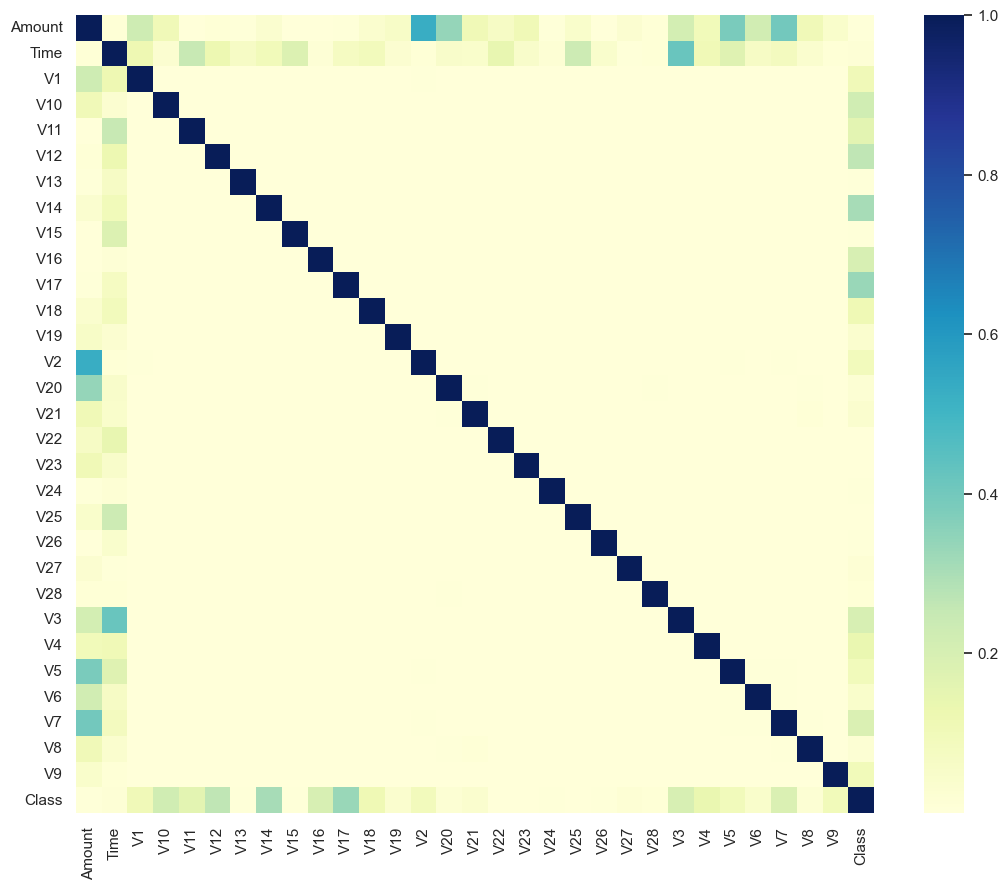

In [200]:

###############################################################################
#              Feature Selection: Removing highly correlated features      #
###############################################################################
# Filter Method: 
# Make correlation matrix
corr_matrix = train_df.corr().abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))



Las variables se encuentran poco correlacionadas como se observa en la imagen Amount tiene algunas V medianamente correlaciondas como V2, v3, V7 pero nada que afecte nuestros modelos 

# Split the data 
separamos la data en training y test en ≈70%y 30% con los target estratificados para mantener las mismas proporciones para que no haya diferencia al estar tan desbalanceada la data

In [203]:
X_train_1, X_test, y_train_1, y_test = train_test_split(X_train, y_train, shuffle=True, stratify=y_train, random_state=42)

print(X_train_1.shape, X_test.shape, y_train_1.shape, y_test.shape)

(202924, 30) (67642, 30) (202924,) (67642,)


In [204]:
y_train_1.value_counts(normalize=True)

0    0.998275
1    0.001725
Name: Class, dtype: float64

In [205]:
y_test.value_counts(normalize=True)

0    0.99827
1    0.00173
Name: Class, dtype: float64

**El objetivo del algoritmo MRM “minimum redundancy - maximum relevance”** es seleccionar características calculando la redundancia entre características y la relevancia entre características y el vector de clase. Adopta la teoría de la información mutua para medir la redundancia y la relevancia. El algoritmo se utiliza en la selección de características para identificar las más informativas en un conjunto de datos. El algoritmo es especialmente útil en conjuntos de datos de alta dimensión en los que el número de características es mucho mayor que el número de muestras.
En este caso vi las variables mas importantes segun este algoritmo pero solo lo voy a tener como guia por que voy a probar con todas las variable, ya que todan son importantes segun information value y estan poco correlaciondas

In [206]:
# mrmr para classificacion
from mrmr import mrmr_classif

selected_features = mrmr_classif(X_train_1,y_train_1, K = 30)

100%|██████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.87it/s]


In [207]:
selected_features  

['V17',
 'V10',
 'V14',
 'V16',
 'V7',
 'V12',
 'V3',
 'V4',
 'V11',
 'V18',
 'V9',
 'V5',
 'V1',
 'V2',
 'V21',
 'V19',
 'V6',
 'V8',
 'V20',
 'V28',
 'V27',
 'V24',
 'V13',
 'V26',
 'V15',
 'V25',
 'V23',
 'Time',
 'Amount',
 'V22']

## pasar las variables Time y Amount a Robust scaler para que no hayan outlier que afecten nuestro modelo 

se utiliza para aplicar un escalado a las características de forma que sea más robusto a los valores atípicos. Concretamente, elimina la mediana y escala los datos de acuerdo a un rango de cuartiles (por defecto el rango intercuantil: el rango de valores entre el 1er cuartil y el 3er cuartil). Esto significa que es menos sensible a los valores atípicos que otros escaladores como StandardScaler o MinMaxScaler. En general, prefiero utilizar RobustScaler cuando se trabaja con datos que contienen valores atípicos.

Voy a escalar solo Amount y Time las variables que empiezan con V me parecen que estan escaladas de una forma al no saber que son no me gustaria escalarlas 

In [211]:
varia= ["Amount","Time"]

varia

In [215]:
transformer = RobustScaler().fit(X_train_1[varia])
X_train_1[varia] = transformer.transform(X_train_1[varia])
X_test[varia] = transformer.transform(X_test[varia])
test_df[varia] = transformer.transform(test_df[varia])

In [213]:
y_test_legit = y_test.value_counts()[0]
y_test_fraud = y_test.value_counts()[1]

# ML


vamos a usar test_df como nombre al test que nos pasaron como un forward testing escondido en el que vamos a predecir los resultados partiendo de las probabilidades, como un desafio de Kaggle.

Se van a probar para seleccionar variable que es mean shap values, con un modelo de decision tree como es random forest fue utilizado  para ver como se encuentra el ranking de variables

In [216]:
model = RandomForestClassifier(max_depth=5, random_state=42, n_estimators= 200, min_samples_leaf= 0.005,min_samples_split= 0.005  )
model.fit(X_train_1, y_train_1)

RandomForestClassifier(max_depth=5, min_samples_leaf=0.005,
                       min_samples_split=0.005, n_estimators=200,
                       random_state=42)

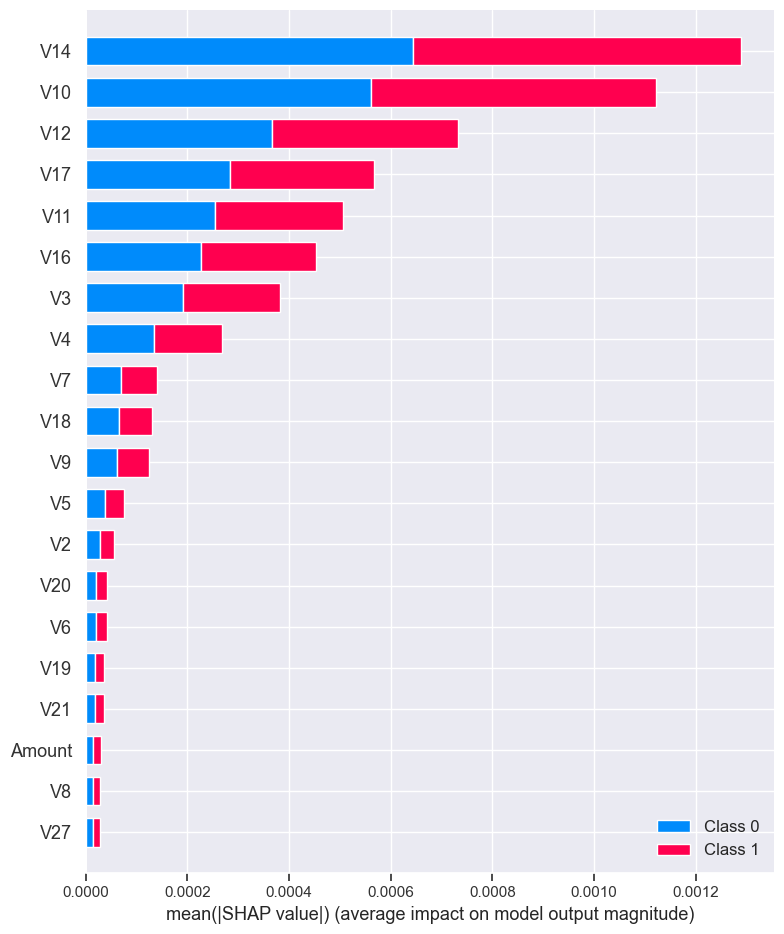

In [217]:
shap_values= shap.TreeExplainer(model).shap_values(X_train_1)
shap.summary_plot(shap_values,X_train_1, plot_type='bar')

### Modelo base line 

voy a ocupar todas las variables no hay gran diferencia en lo que he visto como se comportan y la verdad no se que son cada uno asi que lo vere en el modelo como se desarrolla, todas se ven que son importante para el poder de prediccion de forma individual IV y que no esta correlacionadas que molestaria en un modelo como logistic regresion.

La data esta tan desbalanceada que no ocuparemos accuracy, ROC_AUC o accuracy a menos que trabajemos con los pesos, se podria ocupar SMOTE pero nunca me ha funcionado en dataset profesionales y  la encuentro buena tecnica cosa que podria ahondar mas en una entrevista, encuentro que aumentar datos artificialmente funciona en imagenes no tanto en data tabular.

**ocuparemos  F1 porque es una buena métrica para datos desbalanceados porque se calcula como la media armónica de la precisión y recall de la clase positiva minoritaria. El score F1 sigue siendo capaz de reflejar el verdadero rendimiento del modelo cuando el conjunto de datos está desequilibrado, que es una de las razones por las que es una métrica de uso tan común, tambien ocuparemos una confusion matrix para ver si esta separando las poblaciones que nos importa que seria cuande se produce fraude.**

In [221]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_1, y_train_1)
     

LogisticRegression(max_iter=3000)

In [222]:
lr_clf.score(X_test, y_test)## acuracy

0.9991868957156796

In [223]:
pred_lr=lr_clf.predict(X_test)

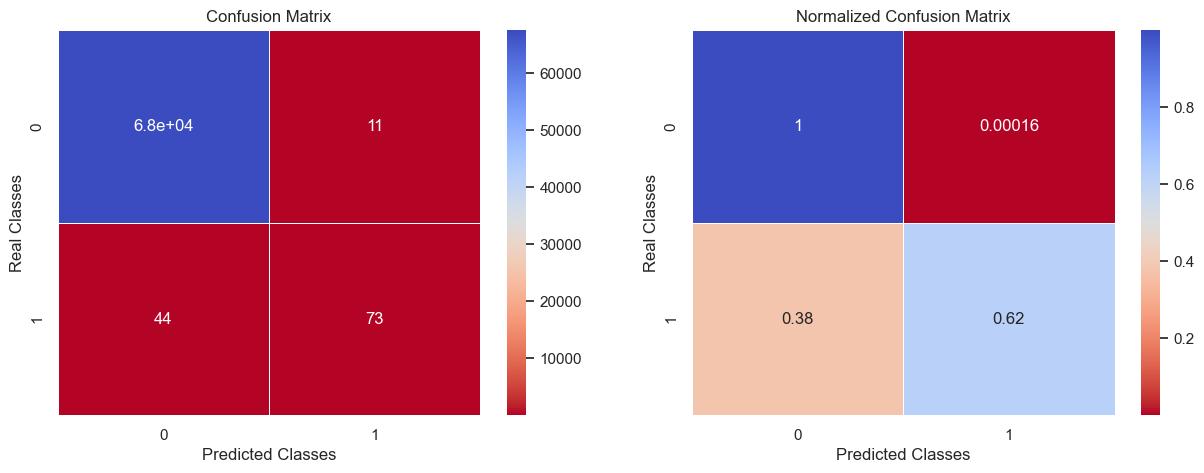

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67525
           1       0.87      0.62      0.73       117

    accuracy                           1.00     67642
   macro avg       0.93      0.81      0.86     67642
weighted avg       1.00      1.00      1.00     67642



In [225]:
def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

PlotConfusionMatrix(y_test,pred_lr,y_test_legit,y_test_fraud)

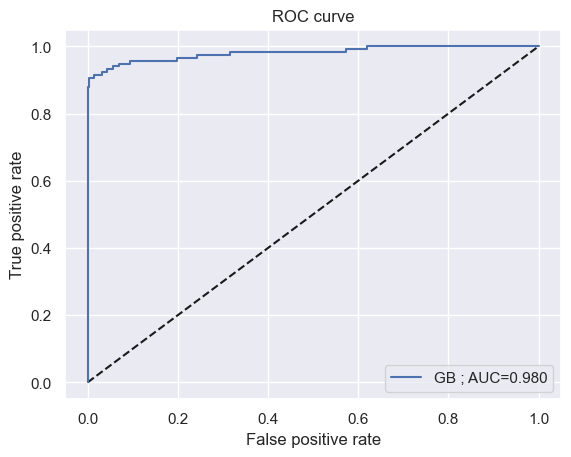

In [226]:
roc_graph(lr_clf.fit(X_train_1, y_train_1),X_test, y_test)

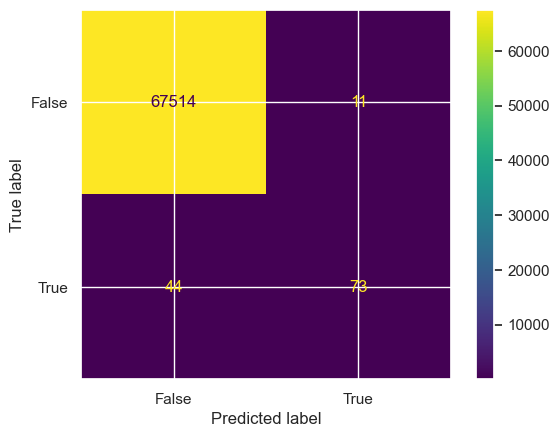

In [227]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, pred_lr)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

**el modelo baseline tiene un muy buen f1 de un 0.73 (especificamente un 0.87 de precision y un 0.62 de recall), y separa de gran manera las poblaciones con esto tenemos lo minimo que tendriamos que tener en modelos mas complejos accuracy y ROC AUC no funciona tan bien en target muy desbalanceados**

## modelo mas complejo: XGBoost

Xtreme Gradient Boosting elegi este modelo como el mas complejo por que para mi es el que ha dado mejores resultados y es uno de los mejores de data tabulada y toda la familia de Gradient boosting,intente balancear los pesos con scale_pos_weight, ocupe cv estratificado y HalvingGridSearchCV por que es bien rapido para modelos mas complejos con muchos hiperparametros

In [218]:
counts = pd.Series(y_train_1).value_counts()
counts

0    202574
1       350
Name: Class, dtype: int64

In [220]:
scale_pos_weight = counts[0] / counts[1]

scale_pos_weight

578.7828571428571

In [228]:
kfold = StratifiedKFold(n_splits=7)
param_grid_2 = {
    "xgbclassifier__max_depth": [ 4, 5],
    "xgbclassifier__gamma": [1,5, 30],
    "xgbclassifier__learning_rate": [ 0.1, 0.3, 0.5],
    "xgbclassifier__min_child_weight": [3, 5],
    "xgbclassifier__reg_lambda": [1,5,50],
    "xgbclassifier__scale_pos_weight": [scale_pos_weight],  # Fix scale_pos_weight
    "xgbclassifier__subsample": [0.8,0.9],
    "xgbclassifier__colsample_bytree": [0.6,0.7, 0.8],
}

In [229]:
clf_best = XGBClassifier()

pipe_best = make_pipeline(clf_best)
search_kbest = HalvingGridSearchCV(pipe_best, param_grid_2, cv=kfold, n_jobs=-1, scoring='f1',  verbose=1000, min_resources="exhaust", factor=4)
search_kbest.fit(X_train_1, y_train_1)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 792
max_resources_: 202924
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 648
n_resources: 792
Fitting 7 folds for each of 648 candidates, totalling 4536 fits
[CV 2/7; 2/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 2/7; 2/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 7/7; 4/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learni

[CV 5/7; 82/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 6/7; 84/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 6/7; 84/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 7/7; 84/648] START xgb

[CV 6/7; 1/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 6/7; 1/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 4/7; 3/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 4/7; 3/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, x

[CV 1/7; 2/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 1/7; 2/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 7/7; 3/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 7/7; 3/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, x

[CV 3/7; 2/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 3/7; 2/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/7; 4/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 3/7; 4/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=1, x

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

[CV 7/7; 140/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 7/7; 140/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/7; 143/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 3/7; 143/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__g

[CV 7/7; 232/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 7/7; 232/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/7; 235/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 5/7; 235/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__ga

[CV 5/7; 145/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 6/7; 145/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 6/7; 145/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 7/7; 147/648] STAR

[CV 5/7; 242/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 5/7; 242/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/7; 245/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 1/7; 245/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__g

[CV 7/7; 157/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 7/7; 157/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 1/7; 158/648] START xgbclassifier__colsample_bytree=0.6, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 1/7; 158/648] END xgbclassifier__colsample_bytree=0.6, xgbclassifier_

[CV 4/7; 277/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 4/7; 277/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 7/7; 279/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 7/7; 279/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__ga

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

[CV 7/7; 278/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/7; 281/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 5/7; 281/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 6/7; 281/648] START

[CV 5/7; 289/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 5/7; 289/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 6/7; 289/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 6/7; 289/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__ga

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

[CV 3/7; 288/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 3/7; 288/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 6/7; 290/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 6/7; 290/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

[CV 5/7; 307/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 5/7; 307/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 6/7; 307/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 6/7; 307/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__ga

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

[CV 5/7; 414/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 5/7; 414/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/7; 417/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 3/7; 417/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifie

[CV 4/7; 426/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/7; 426/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 5/7; 426/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/7; 429/648] S

[CV 2/7; 428/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 2/7; 428/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/7; 428/648] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 3/7; 428/648] END xgbclassifier__colsample_bytree=0.7, xgbclassifier_

[CV 2/7; 437/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 2/7; 437/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 7/7; 439/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 7/7; 439/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__

[CV 3/7; 457/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 3/7; 457/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/7; 457/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 4/7; 457/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__ga

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilofigueroa/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/camilo

----------
iter: 1
n_candidates: 162
n_resources: 3168
Fitting 7 folds for each of 162 candidates, totalling 1134 fits
[CV 6/7; 567/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 6/7; 567/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/7; 570/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.

[CV 4/7; 561/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 4/7; 561/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 7/7; 563/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 7/7; 563/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__g

[CV 3/7; 567/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/7; 567/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 4/7; 567/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 7/7; 569/648] START x

[CV 6/7; 605/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 6/7; 605/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 4/7; 608/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 4/7; 608/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifie

[CV 6/7; 563/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 4/7; 566/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 4/7; 566/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/7; 566/648] START 

[CV 4/7; 3/162] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.923, test=0.667) total time=   0.1s
[CV 4/7; 6/162] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 4/7; 6/162] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.800, test=0.667) total time=   0.1s
[CV 5/7; 6/162] START xgbclas

[CV 1/7; 608/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/7; 610/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 4/7; 610/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/7; 610/648] STAR

[CV 2/7; 63/162] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.909, test=0.500) total time=   0.2s
[CV 2/7; 66/162] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 2/7; 66/162] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.667) total time=   0.2s
[CV 3/7; 66/162] START xgbc

[CV 2/7; 612/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 2/7; 612/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.000) total time=   0.1s
[CV 3/7; 612/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=5, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 3/7; 612/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifi

[CV 2/7; 49/162] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=5, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=50, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=0.667, test=0.400) total time=   0.2s
[CV 7/7; 51/162] START xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9
[CV 7/7; 51/162] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=5, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=5, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.9;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 1/7; 52/162] START xgbc

[CV 1/7; 601/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 1/7; 601/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/7; 601/648] START xgbclassifier__colsample_bytree=0.8, xgbclassifier__gamma=30, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=4, xgbclassifier__min_child_weight=3, xgbclassifier__reg_lambda=1, xgbclassifier__scale_pos_weight=578.7828571428571, xgbclassifier__subsample=0.8
[CV 2/7; 601/648] END xgbclassifier__colsample_bytree=0.8, xgbclassifier_

----------
iter: 2
n_candidates: 41
n_resources: 12672
Fitting 7 folds for each of 41 candidates, totalling 287 fits
----------
iter: 3
n_candidates: 11
n_resources: 50688
Fitting 7 folds for each of 11 candidates, totalling 77 fits
----------
iter: 4
n_candidates: 3
n_resources: 202752
Fitting 7 folds for each of 3 candidates, totalling 21 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
                    estimator=Pipeline(steps=[('xgbclassifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                               

In [230]:
print(search_kbest.score(X_train_1, y_train_1))   
print(search_kbest.score(X_test, y_test))

0.9971509971509972
0.914798206278027


In [231]:
search_kbest.best_estimator_.steps 


[('xgbclassifier',
  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', learning_rate=0.5, max_bin=256,
                max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                max_depth=4, max_leaves=0, min_child_weight=3, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=1, predictor='auto', random_state=0, ...))]

In [232]:
mejor_modelo_1=search_kbest.best_estimator_[0]

In [233]:
print("Best: %f using %s" % (search_kbest.best_score_, search_kbest.best_params_))

Best: 0.851561 using {'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__gamma': 1, 'xgbclassifier__learning_rate': 0.5, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__reg_lambda': 1, 'xgbclassifier__scale_pos_weight': 578.7828571428571, 'xgbclassifier__subsample': 0.8}


In [234]:
best_model=search_kbest.best_estimator_.steps 

In [235]:
search_kbest.best_estimator_.steps

[('xgbclassifier',
  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', learning_rate=0.5, max_bin=256,
                max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                max_depth=4, max_leaves=0, min_child_weight=3, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=1, predictor='auto', random_state=0, ...))]

In [236]:
mejor_modelo=search_kbest.best_estimator_

In [237]:
best_model

[('xgbclassifier',
  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', learning_rate=0.5, max_bin=256,
                max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                max_depth=4, max_leaves=0, min_child_weight=3, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=1, predictor='auto', random_state=0, ...))]

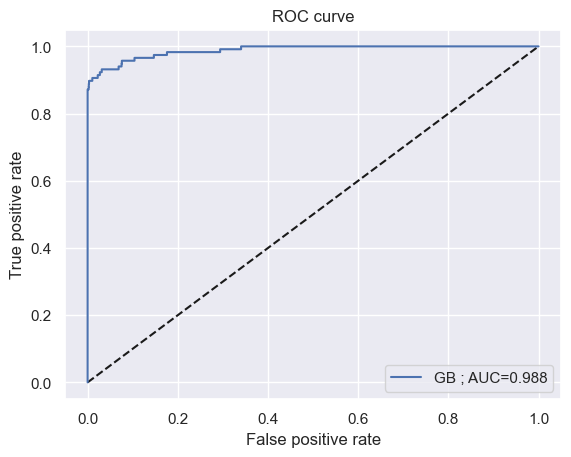

In [238]:
roc_graph(mejor_modelo,X_test, y_test)### roc no funciona muy bien cuando hay data tan desbalanceada 

In [239]:
pred_xgb=mejor_modelo.predict(X_test)

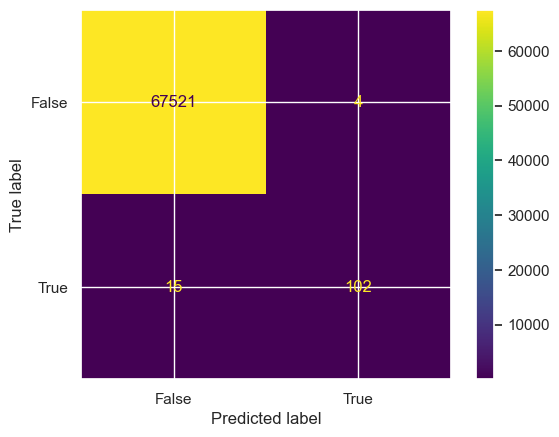

In [241]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, pred_xgb)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

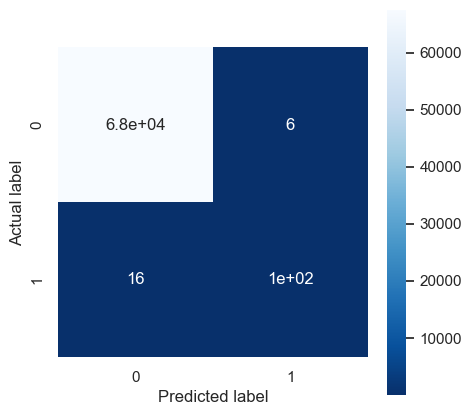

In [242]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [243]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67525
           1       0.96      0.87      0.91       117

    accuracy                           1.00     67642
   macro avg       0.98      0.94      0.96     67642
weighted avg       1.00      1.00      1.00     67642



In [244]:
pred_xgb=mejor_modelo_1.predict(X_test)

In [245]:
mejor_modelo_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [246]:
from xgboost import plot_importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

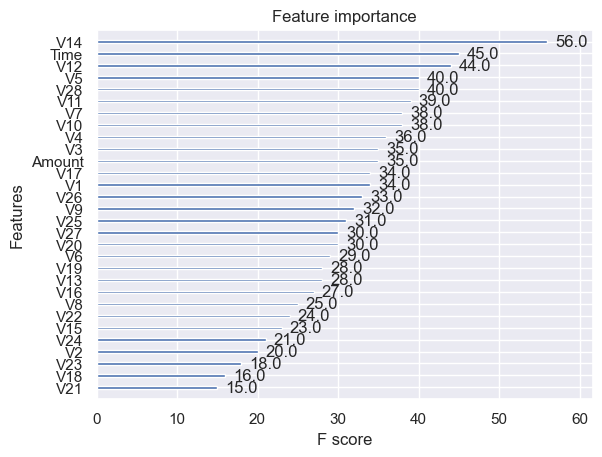

In [247]:
# plot feature importance
plot_importance(mejor_modelo_1)

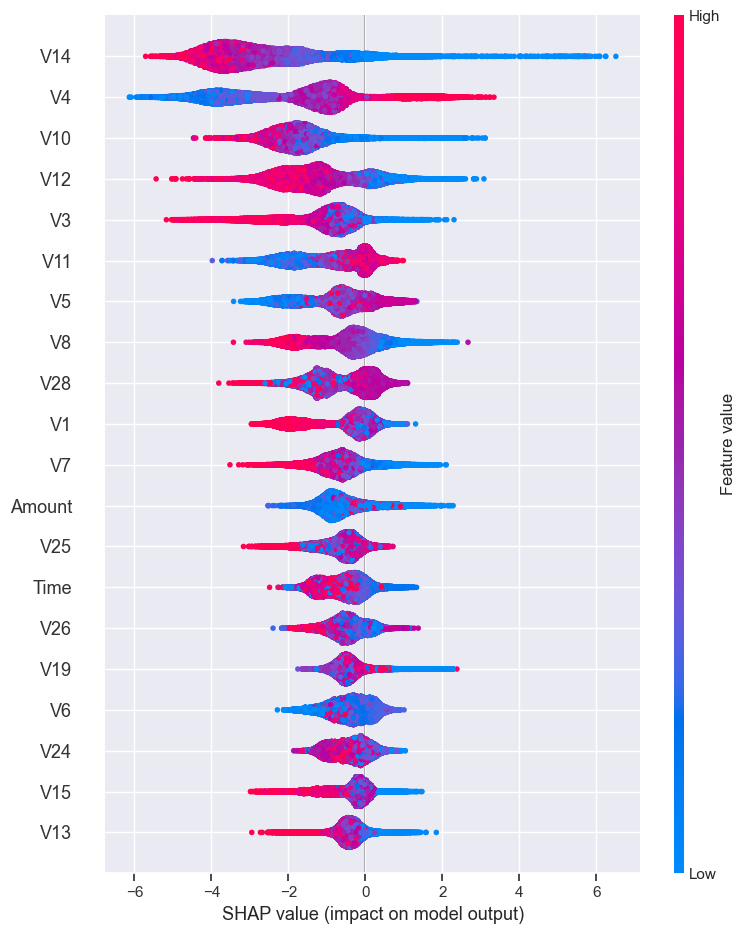

In [267]:
explainer = shap.TreeExplainer(mejor_modelo_1)


shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test)


conclusiones de XGBoost Classifier tiene un 0.91 de F1 (0.96 de precision y 0.87 de recall), y practicamente predice todos los fraudes en la confusion matrix, en feature importance y shap values con el modelo final la variable V14 es la mas importante para ambos, y luego vienen las demas creo que todas son importantes pero creo que se podria realizar con 9 variables y tener resultados similares para que los modelos perduren por mas tiempo y alguna de las seleccion de variables podria ser util para encontrar esas variables pero en este caso decidi ocupar todas por que todas me parecieron importantes y no empeoraban el modelo.

## predicciones para mandar de test_df

para mandar las predicciones hay calibrarlas al threshold como se hizo a continuacion

In [248]:
prediccion =mejor_modelo_1.predict_proba(test_df)[:,1]

In [249]:
prediccion

array([6.6839067e-07, 2.1101100e-08, 1.4772008e-05, ..., 2.3426971e-08,
       1.3629442e-10, 4.4107140e-09], dtype=float32)

Text(0.5, 0, 'Probability')

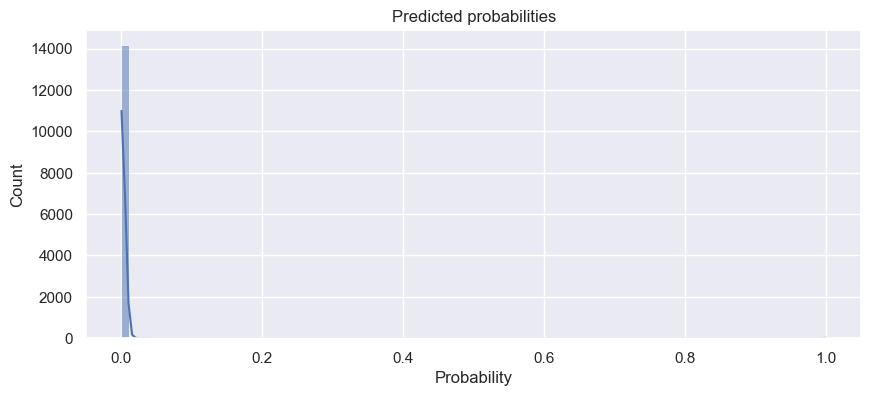

In [250]:
plt.figure(figsize=(10,4))
sns.histplot(prediccion, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

In [251]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(prediccion).sum()/len(prediccion),2))

0.13


Optimal threshold: 0.001


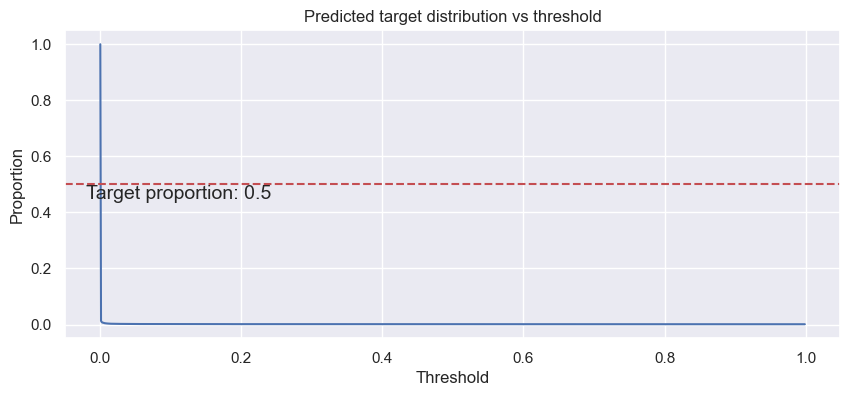

In [252]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.5        # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(prediccion)

In [253]:
T_opt ## mayor a este valor es 1 hubo fraude

0.001

In [254]:
# Classify test set using optimal threshold
preds_tuned=(prediccion>=T_opt).astype(int)

In [255]:
preds_tuned

array([0, 0, 0, ..., 0, 0, 0])

Text(0.5, 1.0, 'Prediction distribution')

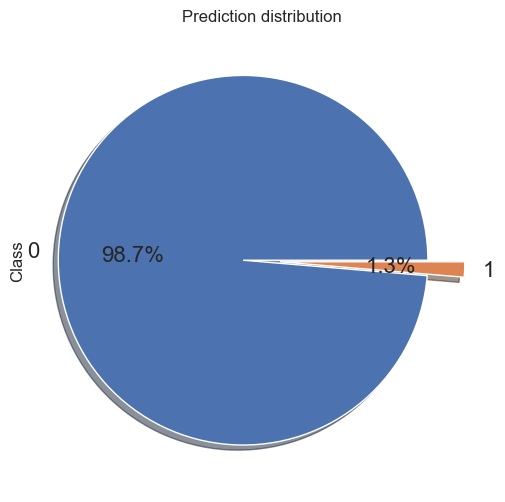

In [256]:
test_df

# Add predictions
test_df['Class']=preds_tuned


# Prediction distribution
plt.figure(figsize=(6,6))
test_df['Class'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

                                              

In [257]:
test_df

Amount      Time        V1       V10       V11       V12       V13  \
0     -0.253531 -0.991754 -0.394816 -0.387105 -0.748656  0.317262  1.209455   
1      1.506503  0.807074  1.788871  0.769936  0.039972  0.012588 -0.883865   
2     -0.279961  0.833957  2.064625 -0.409513 -0.364298  0.585688  0.829608   
3     -0.296882  0.839777 -1.575180  0.290898  0.446495  0.616709 -0.365459   
4     -0.289610  0.701387  2.064998 -0.370744 -0.587547 -0.110537 -0.479552   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.209901 -0.031816  1.219269  0.104569  1.081049  0.762845  0.033258   
14237 -0.013984  0.118671 -0.038516 -0.293283  0.456979 -2.419304  1.145454   
14238 -0.289610  0.033166  2.055343  0.027649 -0.473535  1.135669  1.333175   
14239  0.041952 -0.955015 -0.104979  0.533233  0.994111  0.219665  0.838210   
14240  0.250315  0.007281  1.319814  0.752926 -0.542543 -0.117493  0.370550   

            V14       V15       V16       V17       V18       V19        V2  \
0     -0.089114  1.045811  0.101501 -0.479842 -0.656485 -0.035922  1.054418   
1     -0.077202  0.430576 -0.626788 -0.724333  2.616003 -0.927266 -1.609232   
2     -0.991170  0.166048  0.214684  0.494281 -0.499171 -0.033218  0.205540   
3     -0.075622 -0.262793  0.385753 -0.832068  0.384723  0.159865  1.458531   
4     -0.730811  0.309585  0.275997  0.569065 -0.338709 -0.024160  0.112909   
...         ...       ...       ...       ...       ...       ...       ...   
14236  0.359111  0.484284  0.702875 -0.832088  0.345603  0.169439  0.069726   
14237  0.916726 -1.265461 -1.165619  0.709838 -0.484892  0.904466  0.534755   
14238  0.027602 -0.052358 -0.223572 -0.304456 -1.114867  0.065799  0.034796   
14239 -0.024492 -1.180382  1.137234 -0.356103 -1.000609  0.341051  0.326376   
14240  0.177993  0.795444 -1.362906 -0.085248  0.993349 -0.939500 -0.389476   

            V20       V21       V22       V23       V24       V25       V26  \
0      0.160783 -0.243154 -0.548388 -0.107138 -0.757097 -0.119197  0.149368   
1     -0.440207 -0.024857  0.253865  0.145478 -0.460257 -0.564027 -0.270155   
2     -0.113004 -0.348162 -0.853455  0.339981  0.529735 -0.250244  0.172699   
3      0.354805 -0.232099 -0.362648 -0.072512 -0.445475 -0.140472 -0.277620   
4     -0.198280 -0.363631 -0.960298  0.356301  0.493859 -0.294282  0.177159   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.074539 -0.075446 -0.250334  0.010486  0.006473  0.270530  0.234377   
14237  0.069741 -0.654840 -1.162169  0.112984  0.569864 -0.869850 -1.095726   
14238 -0.150138 -0.269053 -0.570930  0.332103  0.021611 -0.270185  0.196849   
14239  0.226259  0.380917  1.103479 -0.058097  0.060992 -0.585920 -0.424593   
14240 -0.434379 -0.345765 -0.570930 -0.008269  0.401972  0.382698  0.500534   

            V27       V28        V3        V4        V5        V6        V7  \
0      0.287360  0.111322  1.206361 -0.289232  0.610284  0.081529  0.687721   
1      0.066486 -0.013645  0.117193 -0.260803 -1.742005  0.318536 -1.551666   
2     -0.054478 -0.029073 -1.678882  0.408388  0.504149 -0.791406  0.224242   
3      0.246154  0.077137  0.996709 -1.379689 -0.231059 -0.108209  0.159405   
4     -0.062905 -0.032004 -1.705326  0.420547  0.388005 -0.822799  0.134514   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.025057  0.007338  0.557817  0.449976 -0.445903 -0.356850 -0.247844   
14237 -0.196449 -0.252792  0.346520  0.181320  2.881003  4.651889  0.261806   
14238 -0.059141 -0.057850 -1.039231  0.396207  0.001705 -1.098979  0.255820   
14239  0.424716  0.268164  0.208022 -1.892027  0.237738 -1.023539  0.680444   
14240 -0.030260  0.018835  0.236381 -0.098582 -0.920255 -1.028215 -0.218477   

             V8        V9  Class  
0      0.065341 -0.501623      0  
1      0.326577  0.679773      0  
2     -0.256225  0.373726      0  
3      0.465605  0.893678      0  
4     -0.181677  0.572015      0  
...

In [258]:
test_df["Class"].value_counts()

0    14051
1      190
Name: Class, dtype: int64

In [259]:
test_df["Class"].value_counts(normalize=True)

0    0.986658
1    0.013342
Name: Class, dtype: float64

In [260]:
test_df

Amount      Time        V1       V10       V11       V12       V13  \
0     -0.253531 -0.991754 -0.394816 -0.387105 -0.748656  0.317262  1.209455   
1      1.506503  0.807074  1.788871  0.769936  0.039972  0.012588 -0.883865   
2     -0.279961  0.833957  2.064625 -0.409513 -0.364298  0.585688  0.829608   
3     -0.296882  0.839777 -1.575180  0.290898  0.446495  0.616709 -0.365459   
4     -0.289610  0.701387  2.064998 -0.370744 -0.587547 -0.110537 -0.479552   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.209901 -0.031816  1.219269  0.104569  1.081049  0.762845  0.033258   
14237 -0.013984  0.118671 -0.038516 -0.293283  0.456979 -2.419304  1.145454   
14238 -0.289610  0.033166  2.055343  0.027649 -0.473535  1.135669  1.333175   
14239  0.041952 -0.955015 -0.104979  0.533233  0.994111  0.219665  0.838210   
14240  0.250315  0.007281  1.319814  0.752926 -0.542543 -0.117493  0.370550   

            V14       V15       V16       V17       V18       V19        V2  \
0     -0.089114  1.045811  0.101501 -0.479842 -0.656485 -0.035922  1.054418   
1     -0.077202  0.430576 -0.626788 -0.724333  2.616003 -0.927266 -1.609232   
2     -0.991170  0.166048  0.214684  0.494281 -0.499171 -0.033218  0.205540   
3     -0.075622 -0.262793  0.385753 -0.832068  0.384723  0.159865  1.458531   
4     -0.730811  0.309585  0.275997  0.569065 -0.338709 -0.024160  0.112909   
...         ...       ...       ...       ...       ...       ...       ...   
14236  0.359111  0.484284  0.702875 -0.832088  0.345603  0.169439  0.069726   
14237  0.916726 -1.265461 -1.165619  0.709838 -0.484892  0.904466  0.534755   
14238  0.027602 -0.052358 -0.223572 -0.304456 -1.114867  0.065799  0.034796   
14239 -0.024492 -1.180382  1.137234 -0.356103 -1.000609  0.341051  0.326376   
14240  0.177993  0.795444 -1.362906 -0.085248  0.993349 -0.939500 -0.389476   

            V20       V21       V22       V23       V24       V25       V26  \
0      0.160783 -0.243154 -0.548388 -0.107138 -0.757097 -0.119197  0.149368   
1     -0.440207 -0.024857  0.253865  0.145478 -0.460257 -0.564027 -0.270155   
2     -0.113004 -0.348162 -0.853455  0.339981  0.529735 -0.250244  0.172699   
3      0.354805 -0.232099 -0.362648 -0.072512 -0.445475 -0.140472 -0.277620   
4     -0.198280 -0.363631 -0.960298  0.356301  0.493859 -0.294282  0.177159   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.074539 -0.075446 -0.250334  0.010486  0.006473  0.270530  0.234377   
14237  0.069741 -0.654840 -1.162169  0.112984  0.569864 -0.869850 -1.095726   
14238 -0.150138 -0.269053 -0.570930  0.332103  0.021611 -0.270185  0.196849   
14239  0.226259  0.380917  1.103479 -0.058097  0.060992 -0.585920 -0.424593   
14240 -0.434379 -0.345765 -0.570930 -0.008269  0.401972  0.382698  0.500534   

            V27       V28        V3        V4        V5        V6        V7  \
0      0.287360  0.111322  1.206361 -0.289232  0.610284  0.081529  0.687721   
1      0.066486 -0.013645  0.117193 -0.260803 -1.742005  0.318536 -1.551666   
2     -0.054478 -0.029073 -1.678882  0.408388  0.504149 -0.791406  0.224242   
3      0.246154  0.077137  0.996709 -1.379689 -0.231059 -0.108209  0.159405   
4     -0.062905 -0.032004 -1.705326  0.420547  0.388005 -0.822799  0.134514   
...         ...       ...       ...       ...       ...       ...       ...   
14236 -0.025057  0.007338  0.557817  0.449976 -0.445903 -0.356850 -0.247844   
14237 -0.196449 -0.252792  0.346520  0.181320  2.881003  4.651889  0.261806   
14238 -0.059141 -0.057850 -1.039231  0.396207  0.001705 -1.098979  0.255820   
14239  0.424716  0.268164  0.208022 -1.892027  0.237738 -1.023539  0.680444   
14240 -0.030260  0.018835  0.236381 -0.098582 -0.920255 -1.028215 -0.218477   

             V8        V9  Class  
0      0.065341 -0.501623      0  
1      0.326577  0.679773      0  
2     -0.256225  0.373726      0  
3      0.465605  0.893678      0  
4     -0.181677  0.572015      0  
...

In [263]:
# Output to csv
test_df.to_csv('creditcard_test_evaluate.csv', index=True)